# **Brain Tumor Binary Classification from MRI images using Convolutional Neural Network and VGG16 with Transfer Learning**

Aim: The goal of this project is to accurately classify whether a brain MRI image is tumorous or not. To be more specific, we are going to see how convolutional neural networks (CNNs) and VGG16 model with transfer learning can be used in computer vision to detect useful patterns in visual data in order to classify images using TensorFlow and keras.

This notebook consists of eight parts:
1. Get a dataset to work with
2. Inspect the data (Visualization)
3. Create the dataset and visualize the data
4. Preprocess the data
5. Build a CNN model
  * Create a model
  * Compile and Fit the model
  * Improve through experimentation
  * Save and load the model
6. Make predictions with the best model
7. Build the VGG16 model with Transfer Learning
8. Deploy the best model in the application



### **Part 01: Get the data**

The images we are going to work with are from [Kaggle](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection). This dataset contains 3 folders. A 'no' folder which contains 1500 brain MRI images that are no-tumorous, a 'yes' folder which contains 1500 brain MRI images that are tumorous and a 'pred' folder with 60 brain MRI images to make predictions. The dataset is imported directly from kaggle into the google colab using the command API of the dataset.

In [113]:
# Upload the API key from my kaggle account
from google.colab import files

upload = files.upload()

for fn in upload.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(upload[fn])))
  
# move the kaggle.json into the folder where tha API expects to find it 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [114]:
# download the dataset
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [115]:
import zipfile

# unzip the dataset and read it
zip_ref = zipfile.ZipFile("brain-tumor-detection.zip", "r")
zip_ref.extractall()
zip_ref.close()

## **Part 02: Inspect the data**

In [242]:
# import necessary libraries

import os
import pathlib
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from keras.applications import vgg16
from keras.models import Model

In [117]:
# inspect the 'no' directory
!ls no

no0.jpg     no1194.jpg	no1388.jpg  no230.jpg  no424.jpg  no618.jpg  no811.jpg
no1000.jpg  no1195.jpg	no1389.jpg  no231.jpg  no425.jpg  no619.jpg  no812.jpg
no1001.jpg  no1196.jpg	no138.jpg   no232.jpg  no426.jpg  no61.jpg   no813.jpg
no1002.jpg  no1197.jpg	no1390.jpg  no233.jpg  no427.jpg  no620.jpg  no814.jpg
no1003.jpg  no1198.jpg	no1391.jpg  no234.jpg  no428.jpg  no621.jpg  no815.jpg
no1004.jpg  no1199.jpg	no1392.jpg  no235.jpg  no429.jpg  no622.jpg  no816.jpg
no1005.jpg  no119.jpg	no1393.jpg  no236.jpg  no42.jpg   no623.jpg  no817.jpg
no1006.jpg  no11.jpg	no1394.jpg  no237.jpg  no430.jpg  no624.jpg  no818.jpg
no1007.jpg  no1200.jpg	no1395.jpg  no238.jpg  no431.jpg  no625.jpg  no819.jpg
no1008.jpg  no1201.jpg	no1396.jpg  no239.jpg  no432.jpg  no626.jpg  no81.jpg
no1009.jpg  no1202.jpg	no1397.jpg  no23.jpg   no433.jpg  no627.jpg  no820.jpg
no100.jpg   no1203.jpg	no1398.jpg  no240.jpg  no434.jpg  no628.jpg  no821.jpg
no1010.jpg  no1204.jpg	no1399.jpg  no241.jpg  no435.jpg  no629.jpg  

In [118]:
# Walk through the 'no' directory and list number of files
for dirpath, dirnames, filenames in os.walk("no"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 1500 images in 'no'.


In [119]:
# also walk through in the 'yes' directory
for dirpath, dirnames, filenames in os.walk("yes"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 1500 images in 'yes'.


In [120]:
# Another way to find out how many images are in a file
no_tumor_images = len(os.listdir("no"))
tumor_images = len(os.listdir("yes"))

# print the length of the images
print(f'Number of no tumorous brain images: {no_tumor_images}')
print(f'Number of tumorous brain images: {tumor_images}')

Number of no tumorous brain images: 1500
Number of tumorous brain images: 1500


So, we've got a collection of 1500 images of tumorous and no tumorous brain images.

In [121]:
#view an image

def view_random_image(target_dir):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])

  # show the image
  plt.imshow(img)
  plt.axis("off"); 
  plt.title(target_dir)

  print(f"Image shape: {img.shape}") # print the shape of the image

  return img

Image shape: (225, 225, 3)


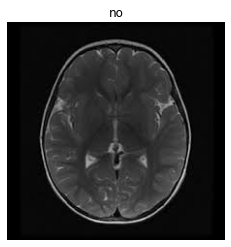

In [122]:
# View a random image from the targeted folder ('no')
image1 = view_random_image(target_dir='no')


Image shape: (237, 213, 3)


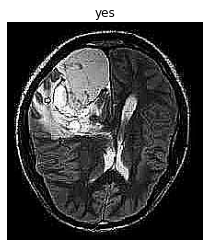

In [123]:
# View a random image from the 'yes' folder
image2 = view_random_image(target_dir='yes')

Alongside the plotted image, we printed the image shape. 

The computer sees the image in the form of a big array (tensor).

In [124]:
# view the  first image (actually just a big tensor/array)
image1

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [125]:
# view the image shape
image1.shape #returns (width,height,colour channel)

(225, 225, 3)

Looking the shape of the image more carefully, we see that is in the form (width,height,colour channel).

The width and height values vary but the colour channel value remains always the same (3) because we are dealing with colour images.

The values in the image tensor are between 0 and 255 and this is because that's the possible range for red, green and blue values.

## **Part 03: Create the data set and visualize the data**

As it was mentioned before, there are 2 folders of 1500 MRI images in each. In order to bulid the models , a dataset will be created which will contain all these images and their associated label. Let's walk through in the directories again to read the images and store them in a list as well as their associated label in another list.

This time, we are going to use the OpenCV library designed for computer vision problems which loads an image from a specific file.

In [168]:
# create two empty lists to store the images and the labels for each image
dataset = []
label = []

# create a path and then return the entries in the directory given by the path
image_directory_no = 'no/'

# path for with no brain tumor
no_tumor_images = os.listdir(image_directory_no)


for i, image_name in enumerate(no_tumor_images):
    #split the image name and check if the type is jpg
    if(image_name.split('.')[1]=='jpg'):
        
        # load the image from the targeted directory 
        image=cv2.imread(image_directory_no + image_name)
        
        # convert the PIL image into an array
        image=Image.fromarray(image,'RGB')
        
        # resize the image size so all the images have the same width and height
        image=image.resize(((64,64)))
        
        # convert the image into numpy array and append it into our dataset
        dataset.append(np.array(image))
        
        # append the associated labels of the image in the label list and convert them in an array format
        label.append(0) #0 goes for no tumorous brain images


In [169]:
# check the length of the dataset
len(dataset)

1500

Repeat the same process for the other directory which contains the tumorous brain images and append them in the dataset.

In [170]:
# create a path and then return the entries in the directory given by the path
image_directory_yes = 'yes/'

# path for tumorous brain images
tumor_images = os.listdir(image_directory_yes)

for i, image_name in enumerate(tumor_images):
    #split the image name and check if the type is jpg
    if(image_name.split('.')[1]=='jpg'):
        
        # load the image from the targeted directory 
        image=cv2.imread(image_directory_yes + image_name)
        
        # convert the PIL image into an array
        image=Image.fromarray(image,'RGB')
        
        # resize the image size so all the images have the same width and height
        image=image.resize(((64,64)))
        
        # convert the image into numpy array and append it into our dataset
        dataset.append(np.array(image))
        
        # append the associated labels of the image in the label list and convert them in an array format
        label.append(1) #1 goes for  tumorous brain images

In [171]:
#check the length of the dataset and the label variable
print(f'The dataset contains {len(dataset)} images')
print(f'Labels in each image: {len(label)}')

The dataset contains 3000 images
Labels in each image: 3000


The length of the dataset and the labels are the same. That means that we accesed the images from the folders correctly. Since the type of the dataset and label is a list, we have to convert it into a numpy array in order to feed the models.

In [172]:
# convert the dataset and label into a numpy array
dataset = np.array(dataset)
label = np.array(label)

In [173]:
#check the type
type(dataset)
type(label)

numpy.ndarray

In [174]:
#check the shape of the dataset
dataset.shape

(3000, 64, 64, 3)

In [175]:
#reshape the label 
#label = label.reshape(3000,2)
label.shape

(3000,)

So, 3000 brain MRI images each with shape (64,64,3).

In [176]:
# more visualizations
def image(data,i):
    #plot the i image
    plt.imshow(data[i])
    print(f'The shape is: {data[i].shape}')
    if label[1] == 0:
      plt.title('No tumor in the brain')
    else:
      plt.title('Tumor in the brain')

The shape is: (64, 64, 3)


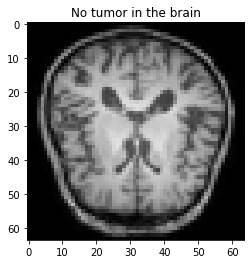

In [177]:
#view the image
image(dataset,1)

**Create training and testing data sets.**

From sklearn library, we use the train_test_split() function to split the dataset intto training and testing subsets. The dataset will be shuffled and the test size will be 20% of the total data.

In [178]:
# split the dataset into training and testing subsets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(dataset,label,test_size=0.2,
                                                                  random_state=0,shuffle=True)

In [179]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n") 
print(f"Training label: {train_labels[0]}")

Training sample:
[[[ 81  81  81]
  [ 42  42  42]
  [176 176 176]
  ...
  [  2   2   2]
  [  2   2   2]
  [  2   2   2]]

 [[ 82  82  82]
  [ 25  25  25]
  [131 131 131]
  ...
  [  3   3   3]
  [  2   2   2]
  [  2   2   2]]

 [[ 78  78  78]
  [ 39  39  39]
  [ 53  53  53]
  ...
  [  3   3   3]
  [  3   3   3]
  [  2   2   2]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  9   9   9]
  [  6   6   6]
  [  5   5   5]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  6   6   6]
  [  5   5   5]
  [  5   5   5]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  5   5   5]
  [  6   6   6]
  [  5   5   5]]]

Training label: 1


We get a large list of numbers (tensor), followed (the data) by a single number (the class label).

What about the shapes?

In [180]:
#check the shape of our data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((2400, 64, 64, 3), (2400,), (600, 64, 64, 3), (600,))

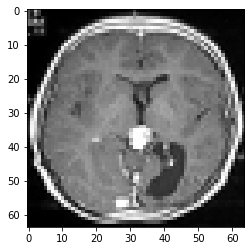

In [181]:
#plot a single example
plt.imshow(train_data[0]);

In [182]:
#check our samples label
train_labels[0]

1

Our labels are in numerical form and while this is the key point to train a Neural Network, it's also a good idea to have them in human readable form.

In [183]:
# create a list of the class names
class_names = ['No Brain Tumor','Brain Tumor']

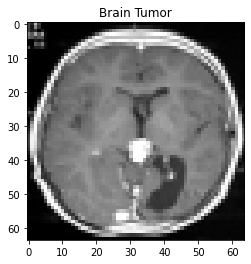

In [184]:
#plot an example image and its label
plt.imshow(train_data[17])
plt.title(class_names[train_labels[17]]);

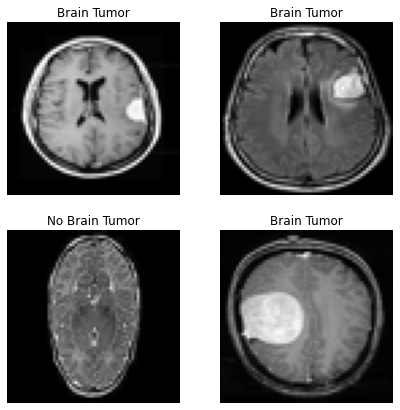

In [185]:
#plot multiple random images from our training data set
plt.figure(figsize=(7,7))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    rand_index = random.choice(range(len(train_data)))
    plt.imshow(train_data[rand_index])
    plt.title(class_names[train_labels[rand_index]])
    plt.axis(False)

## **Part 04: Preprocess the data**

It's widely known that many machine learning models, including Neural Network tend to perform better when the values are between 0 and 1. Therefore, to **scale** or **normalize** the data is one of the most important and common preprocessing steps when working with images. Scaling the pixel values can be achieved by dividing the image arrays by 255. Using TensorFlow, we can rescale the data using the **Normalize** function.

In [188]:
# Normalize the data
train_data_norm = tf.keras.utils.normalize(train_data,axis=1)
test_data_norm = tf.keras.utils.normalize(test_data,axis=1)

In [189]:
# check a single example of normalized data
train_data_norm[1]

array([[[0.21516629, 0.21516629, 0.21516629],
        [0.93774876, 0.93774876, 0.93774876],
        [0.93619832, 0.93619832, 0.93619832],
        ...,
        [0.9327982 , 0.9327982 , 0.9327982 ],
        [0.93560172, 0.93560172, 0.93560172],
        [0.21813354, 0.21813354, 0.21813354]],

       [[0.12683487, 0.12683487, 0.12683487],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.11797018, 0.11797018, 0.11797018]],

       [[0.12456996, 0.12456996, 0.12456996],
        [0.        , 0.        , 0.        ],
        [0.01671783, 0.01671783, 0.01671783],
        ...,
        [0.01636488, 0.01636488, 0.01636488],
        [0.        , 0.        , 0.        ],
        [0.12464774, 0.12464774, 0.12464774]],

       ...,

       [[0.12230505, 0.12230505, 0.12230505],
        [0.        , 0.        , 0.        ],
        [0.        , 0

## **Part 05: Build the CNN model**

Convolutional Neural Networks work in a way that can understand a natural image well enough and solve computer vision problems, especially image classication tasks. The goal of a CNN model is to learn the most important features from the brain MRI images as well as to classify them. Let's build a simple CNN model and see how it perfoms in the dataset and then try to improve it.

In [190]:

#create a simple CNN model
model_1 = keras.Sequential([
          layers.Conv2D(filters=32,
                        kernel_size=(3,3),
                        activation='relu',
                        input_shape=(64,64,3)),
          layers.MaxPooling2D(pool_size=(2,2)),

          layers.Flatten(),
          layers.Dense(units=100,activation='relu'),
          layers.Dense(units=10,activation='relu'),
          layers.Dense(units=1,activation='sigmoid')
])

In [191]:
#compile the model
model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [192]:
#fit the model
history_1 = model_1.fit(train_data_norm,train_labels,
                    epochs=10, batch_size=32,
                    verbose=1,
                    validation_data = (test_data_norm,test_labels))

Epoch 1/10
75/75 [==============================] - 1s 9ms/step - loss: 0.4739 - accuracy: 0.7758 - val_loss: 0.3224 - val_accuracy: 0.8467
Epoch 2/10
75/75 [==============================] - 0s 6ms/step - loss: 0.2504 - accuracy: 0.9096 - val_loss: 0.1971 - val_accuracy: 0.9367
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 0.1327 - accuracy: 0.9588 - val_loss: 0.1332 - val_accuracy: 0.9583
Epoch 4/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0900 - accuracy: 0.9767 - val_loss: 0.1051 - val_accuracy: 0.9633
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.9896 - val_loss: 0.1007 - val_accuracy: 0.9733
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.0753 - val_accuracy: 0.9750
Epoch 7/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.1100 - val_accuracy: 0.9700
Epoch 8/10
75/75 [==

In [193]:
#check the summary of the model
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 30752)             0         
                                                                 
 dense_19 (Dense)            (None, 100)               3075300   
                                                                 
 dense_20 (Dense)            (None, 10)                1010      
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                     

In [194]:
#to inspect the performance of each model,a seperate plot is used for training and validation data
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

   # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

  # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

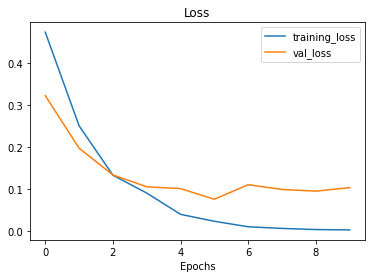

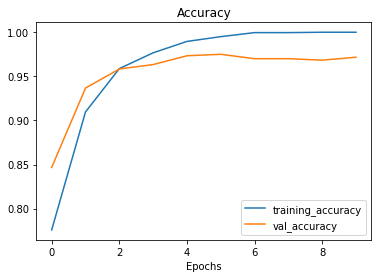

In [195]:
#plot the learning curves of the model_1
plot_loss_curves(history_1)

Model_1 is overfitting the training dataset. It can be observed that the validation loss starts to increase and therefore the model is likely to overfit the training dataset.

Overfitting can be prevented by changing the complexity of the model or by adding some special layers such as the Dropout layer or the BatchNormalization layer.

In [196]:
#create a model with higher complexity


model_2 = keras.Sequential([
            layers.Conv2D(filters = 32,
                          kernel_size = (3,3),
                          activation='relu',
                          input_shape=(64,64,3)),
            layers.MaxPooling2D(pool_size=(2,2)),

            layers.Conv2D(32,(3,3),activation='relu'),
            layers.MaxPooling2D(pool_size=(2,2)),

            layers.Conv2D(64,(3,3),activation='relu'),
            layers.MaxPooling2D(pool_size=(2,2)),

            layers.Flatten(),
            layers.Dense(100,activation='relu'),
            layers.Dense(1,activation='sigmoid')

])

In [197]:
#compile the model
model_2.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

In [198]:
#fit the model
history_2 = model_2.fit(train_data_norm,train_labels,
                    epochs=10, batch_size=16,
                    verbose=1,
                    validation_data = (test_data_norm,test_labels))

Epoch 1/10
150/150 [==============================] - 1s 6ms/step - loss: 0.5611 - accuracy: 0.7163 - val_loss: 0.4382 - val_accuracy: 0.7817
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - loss: 0.3581 - accuracy: 0.8487 - val_loss: 0.3158 - val_accuracy: 0.8533
Epoch 3/10
150/150 [==============================] - 1s 5ms/step - loss: 0.2604 - accuracy: 0.8917 - val_loss: 0.2293 - val_accuracy: 0.9017
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1723 - accuracy: 0.9408 - val_loss: 0.1765 - val_accuracy: 0.9317
Epoch 5/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1101 - accuracy: 0.9621 - val_loss: 0.1680 - val_accuracy: 0.9350
Epoch 6/10
150/150 [==============================] - 1s 7ms/step - loss: 0.0594 - accuracy: 0.9837 - val_loss: 0.1177 - val_accuracy: 0.9583
Epoch 7/10
150/150 [==============================] - 1s 10ms/step - loss: 0.0292 - accuracy: 0.9921 - val_loss: 0.0998 - val_accuracy: 0.9733
Epoch

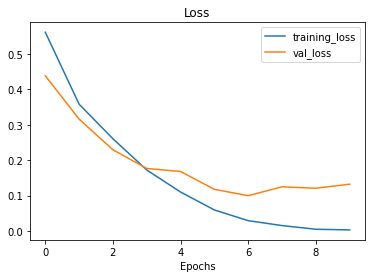

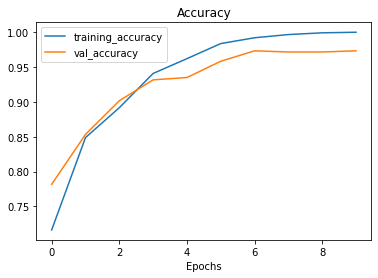

In [199]:
#plot the learning curves 
plot_loss_curves(history_2)

The model is overfitting the training data again as the training loss starts increasing. Sometimes higher complexity doesn't necessarely mean that the cnn model will perfom better.

The model has improved a lot.

In [217]:
#create another model with a dropout layer
model=Sequential()

model.add(Conv2D(32, (3,3), input_shape=(64,64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [218]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [219]:
history = model.fit(train_data_norm,train_labels, 
batch_size=16, 
verbose=1, epochs=10, 
validation_data=(test_data_norm, test_labels),
shuffle=False)

Epoch 1/10
150/150 [==============================] - 1s 7ms/step - loss: 0.5782 - accuracy: 0.7100 - val_loss: 0.4651 - val_accuracy: 0.7533
Epoch 2/10
150/150 [==============================] - 1s 6ms/step - loss: 0.4581 - accuracy: 0.8108 - val_loss: 0.3657 - val_accuracy: 0.8417
Epoch 3/10
150/150 [==============================] - 1s 5ms/step - loss: 0.3607 - accuracy: 0.8483 - val_loss: 0.3036 - val_accuracy: 0.8700
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.2812 - accuracy: 0.8821 - val_loss: 0.2462 - val_accuracy: 0.8950
Epoch 5/10
150/150 [==============================] - 1s 5ms/step - loss: 0.2019 - accuracy: 0.9242 - val_loss: 0.2502 - val_accuracy: 0.9033
Epoch 6/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1548 - accuracy: 0.9429 - val_loss: 0.1815 - val_accuracy: 0.9333
Epoch 7/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1206 - accuracy: 0.9546 - val_loss: 0.1211 - val_accuracy: 0.9600
Epoch 

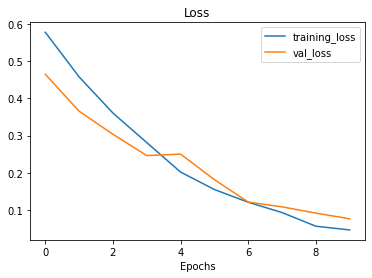

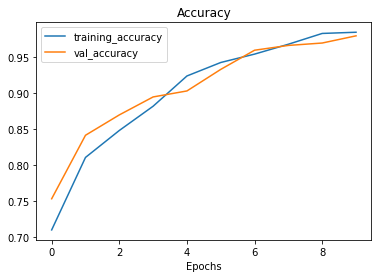

In [220]:
plot_loss_curves(history)

In [221]:
probs = model.predict(test_data_norm)
probs[:3]

array([[9.9035551e-06],
       [6.5150266e-03],
       [9.4456571e-01]], dtype=float32)

In [222]:
test_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])

The prediction's output is in a prediction probability form. This means that how likely the brain image is to be tumorous or not. Since this is a binary classification task, if the probability is higher than 0.5, the prediction is most likely to be the positive class (tumorous image-class 1). On the other hand, if the prediction is under 0.5, the predicted class is 0 (no tumor).
A dataset called preds is created to store the labels depending the probabilty of each image to be tumorous or not.

In [223]:
preds = []
for element in probs:
  if element > 0.5:
    preds.append(1)
  else:
    preds.append(0)

In [224]:
preds[:10]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1]

In [225]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_labels,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       343
           1       0.98      0.97      0.98       257

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [226]:
#a fuction which displays the confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_calc(preds,test_labeles,num_classes):
    positions = np.arange(0,num_classes)
    classes = np.arange(0,num_classes)
    cm=confusion_matrix(preds, test_labels,labels=classes) 
    disp=ConfusionMatrixDisplay(cm,display_labels=classes)
    classes_name = class_names
    plt.figure(figsize=(10,10))
    disp.plot(cmap = "viridis")
    plt.xticks(positions, classes_name)
    plt.yticks(positions, classes_name)
    plt.title('Confusion Matrix')
    return 

<Figure size 720x720 with 0 Axes>

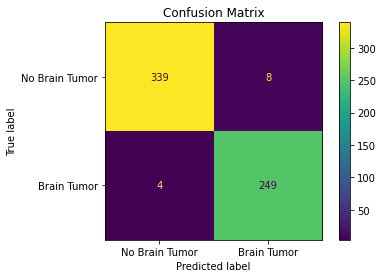

In [227]:
confusion_matrix_calc(preds,test_labels,2)

It can be observed that the proposed model missclassified 12 images. It predicts that 8 of them are tumorous which are not and 4 as tumorous while they have not brain tumor.

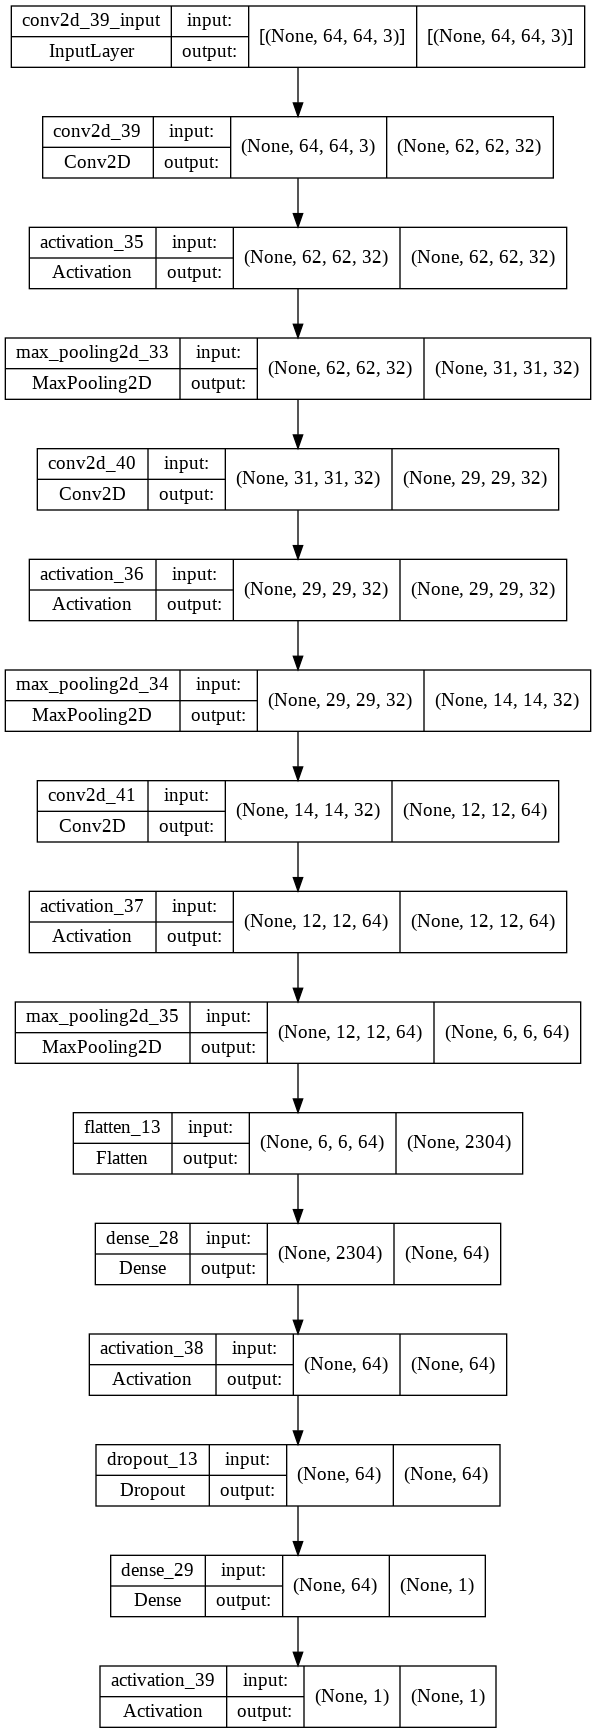

In [228]:
# See the inputs and outputs of each layer from the best model
plot_model(model, show_shapes=True)

In [229]:
#evaluate the model
print('Evaluate on test data')

results = model.evaluate(test_data_norm, test_labels)

#print the results
print('val loss, val accuracy:',results)

Evaluate on test data
19/19 [==============================] - 0s 4ms/step - loss: 0.0761 - accuracy: 0.9800
val loss, val accuracy: [0.07608513534069061, 0.9800000190734863]


In [230]:
#save the model
model.save('final_model_brain_tumor.h5')

## **Part 06: Make predictions with the best model**

To test and evaluate the performance of the model, the pred folder will be used to make predictions and see how the model performs on data that has never seen before. 

In [231]:
#print the classes that we are dealing with
print(class_names)

['No Brain Tumor', 'Brain Tumor']


In [232]:
#load the final model
final_model = load_model('final_model_brain_tumor.h5')

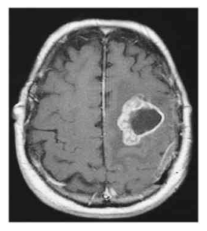

In [233]:
#view an example image from the pred folder
folder = 'pred/'

#walk through inside the folder and select the first image
pred_folder_images = os.listdir(folder)
sample_img = pred_folder_images[0]

# Read in the image and plot it using matplotlib
img = mpimg.imread(folder + "/" + sample_img)

#plot the image
plt.imshow(img)
plt.axis(False)
plt.show()

In [234]:
#check the shape of the image
img.shape

(360, 319, 3)

For the model to make predictions on unseen data, the images have to be in the same shape as the model has been trained on.
Since the final model takes in images of shape (64,64,3), the prediction images have to be reshaped to use them with the model.

Create a function which loads and resize an image to be able to be used from the model. The fuction reads an image from a filename, then it turns it into a tensor and reshape it to (image_shape,image_shape,colour_channel)



In [235]:
def load_and_prep_image(target_filename,image_shape=64):
  
  #read an image from the pred folder 
  image = tf.io.read_file(target_filename)

  #decode the read file into tensor and make sure that color channels are 3
  image = tf.image.decode_image(image,channels=3)

  #resize the image
  image = tf.image.resize(image, size=[image_shape,image_shape])

  #scale the image
  image = image/255.
  return image


In [236]:
#pass the image into the function
brain_image = load_and_prep_image('pred/pred16.jpg')
brain_image

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353]],

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353]],

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353]],

       ...,

       [[0.05882353, 0.05882353, 0.05882353],
        [0.0588

Although the brain image has the right shape as the images the model has been trained on, still a dimension is missing because the model was trained in batches. In reality, it is in the shape of (batch_size,64,64,3). This can be fixed by adding an extra dimension to the image.



In [237]:
# Add an extra axis
print(f"Shape before new dimension: {brain_image.shape}")
brain_image = tf.expand_dims(brain_image, axis=0) # add an extra dimension at axis 0
#steak = pred[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {brain_image.shape}")
brain_image

Shape before new dimension: (64, 64, 3)
Shape after new dimension: (1, 64, 64, 3)


<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
array([[[[0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353]],

        [[0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353]],

        [[0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353]],

        ...,

        [[0.05882353, 0.05882353, 0.

In [ ]:
#make a prediction
pred = model.predict(brain_image)
pred

array([[0.27464452]], dtype=float32)

The prediction's output is in a prediction probability form. This means that how likely the brain image is to be tumorous or not.
Since this is a binary classification task, if the probability is higher than 0.5, the prediction is most likely to be the positive class (tumorous image-class 1). On the other hand, if the prediction is under 0.5, the predicted class is 0 (no tumor).

Create a function to convert the predictions into their class labels and then plot the image with the predicted class.

In [238]:
#index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'No Brain Tumor'

In [239]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

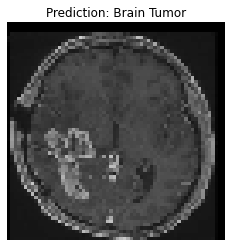

In [240]:
pred_and_plot(model, 'pred/pred13.jpg', class_names)

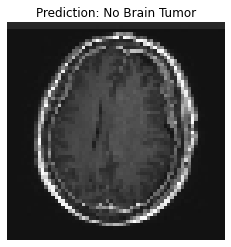

In [241]:
pred_and_plot(model, 'pred/pred26.jpg' , class_names)

## **Part 07: Build the VGG16 model with Transfer Learning**

VGG-16 pre-trained model has already been imported 


In [243]:
#create the base model
img_rows, img_cols = 64,64 

#load the pre-trained model using the imagenet database
vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [257]:
#freeze the layers because they are already trained 
for layer in vgg.layers:
    layer.trainable = False

#print the layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

#add some more layers to the vgg16 input model 
def add_layers(bottom_model, num_classes):
      """creates the top or head of the model that will be 
      placed ontop of the bottom layers"""

      top_model = bottom_model.output
      top_model = GlobalAveragePooling2D()(top_model)
      top_model = Dense(1024,activation='relu')(top_model)
      top_model = Dense(1024,activation='relu')(top_model)
      top_model = Dense(512,activation='relu')(top_model)
      top_model = Dense(num_classes,activation='sigmoid')(top_model)
      return top_model 


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


Number of classes are equal to 1 because sigmoid activation function is used in the training phase.

In [258]:
num_classes = 1

#call the function and use as input model the pre-trained model vgg16
base_model = add_layers(vgg, num_classes)

model_vgg16 = Model(inputs = vgg.input, outputs = base_model)

In [259]:
#check the suammry of the model
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [260]:
#compile the model
model_vgg16.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [261]:
vgg16_history = model_vgg16.fit(train_data_norm,train_labels,
                               epochs=20,
                               batch_size=32,
                               validation_data=(test_data_norm,test_labels))

Epoch 1/20
75/75 [==============================] - 3s 27ms/step - loss: 0.5987 - accuracy: 0.6775 - val_loss: 0.5040 - val_accuracy: 0.7033
Epoch 2/20
75/75 [==============================] - 2s 22ms/step - loss: 0.4754 - accuracy: 0.7675 - val_loss: 0.3807 - val_accuracy: 0.8633
Epoch 3/20
75/75 [==============================] - 2s 23ms/step - loss: 0.4048 - accuracy: 0.8183 - val_loss: 0.3499 - val_accuracy: 0.8433
Epoch 4/20
75/75 [==============================] - 2s 23ms/step - loss: 0.3630 - accuracy: 0.8442 - val_loss: 0.3309 - val_accuracy: 0.8667
Epoch 5/20
75/75 [==============================] - 2s 23ms/step - loss: 0.3163 - accuracy: 0.8629 - val_loss: 0.3042 - val_accuracy: 0.8767
Epoch 6/20
75/75 [==============================] - 2s 23ms/step - loss: 0.2683 - accuracy: 0.8858 - val_loss: 0.2972 - val_accuracy: 0.8750
Epoch 7/20
75/75 [==============================] - 2s 27ms/step - loss: 0.2192 - accuracy: 0.9112 - val_loss: 0.2414 - val_accuracy: 0.9150
Epoch 8/20
75

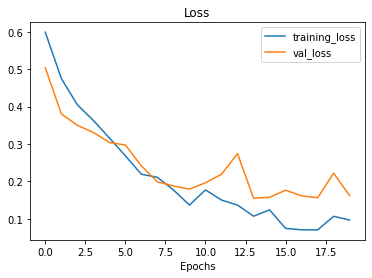

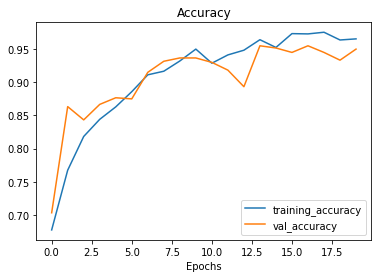

In [262]:
plot_loss_curves(vgg16_history)

In order to make predictions, the same process is repeated.

In [267]:
probs_vgg16= model_vgg16.predict(test_data_norm)
probs[:3]

array([[9.9035551e-06],
       [6.5150266e-03],
       [9.4456571e-01]], dtype=float32)

In [268]:
#create a pred list 
preds_vgg16 = []
for element in probs_vgg16:
  if element > 0.5:
    preds_vgg16.append(1)
  else:
    preds_vgg16.append(0)

In [269]:
#check the first five predictions
preds_vgg16[:5]

[0, 0, 1, 1, 1]

In [270]:
#print the classification report
print(classification_report(test_labels,preds_vgg16))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       343
           1       0.91      0.98      0.94       257

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



<Figure size 720x720 with 0 Axes>

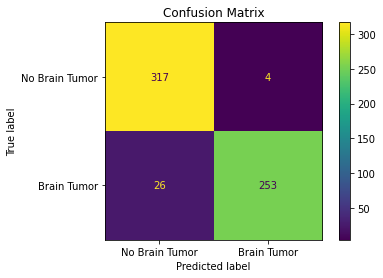

In [271]:
#using the created function, the confusion matrix is displayed
confusion_matrix_calc(preds_vgg16,test_labels,2)

It can be observed that the proposed model missclassified 30 images. It predicts that 4 of them are tumorous which are not and 26 as tumorous while they have not brain tumor.

In order to make predictions to test the pre-trained model, the 'prep_and_plot' function is used.

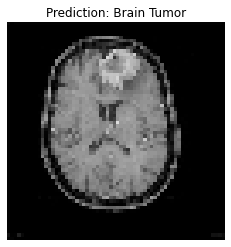

In [272]:
pred_and_plot(model_vgg16, 'pred/pred23.jpg', class_names)

To summarize, both of the proposed models performed very well on data that they have not seen before and most importantly the problem of overfitting is prevented when training the models. However, the CNN model which is built from the scratch performed slightly better than the pre-trained model and it is going to be deployed in the web application.